# Stock Value Prediction

In [14]:
import time

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optax

from flax import linen
from stockdex import Ticker
from turbanet import TurbaTrainState, mse

In [15]:
TIME_WINDOW = 20
HIDDEN_SIZE = 32
EPOCHS = 10_000
LR = 1e-5

In [16]:
TICKERS = ["AAPL", "MSFT", "TSLA", "GOOGL", "AMZN", "NVDA", "META", "XOM", "UNH", "JNJ"]
SWARM_SIZE = len(TICKERS)

## Data Collection

In [17]:
# Create sequences of price data of length TIME_WINDOW
def create_sequences(data, time_window) -> tuple[np.ndarray, np.ndarray]:
    sequences = []
    results = []
    for i in range(len(data) - time_window):
        sequence = data[i : i + time_window]
        sequences.append(sequence)
        results.append(data[i + time_window])
    return np.array(sequences).reshape(-1, time_window, 1), np.array(results).reshape(-1, 1)

In [18]:
def get_ticker_data(ticker, range="1y", dataGranularity="1d"):
    data = Ticker(ticker=ticker).yahoo_api_price(range=range, dataGranularity=dataGranularity)
    close = data["close"]
    close /= np.max(close)
    X_data, y_data = create_sequences(close, TIME_WINDOW)
    return X_data, y_data

In [19]:
ticker_data = [get_ticker_data(ticker) for ticker in TICKERS]
X_data = np.array([data[0] for data in ticker_data])
y_data = np.array([data[1] for data in ticker_data])

## Turba

In [20]:
class TurbaLSTM(linen.Module):
    features: int

    @linen.compact
    def __call__(self, x):
        ScanLSTM = linen.scan(
            linen.OptimizedLSTMCell,
            variable_broadcast="params",
            split_rngs={"params": False},
            in_axes=1,
            out_axes=1,
        )

        lstm = ScanLSTM(self.features)
        input_shape = x[:, 0].shape
        carry = lstm.initialize_carry(jax.random.PRNGKey(0), input_shape)
        carry, x = lstm(carry, x)
        final = x[:, -1]
        output = linen.Dense(1)(final)
        return output

In [21]:
optimizer = optax.adam(learning_rate=LR)

In [22]:
turba_model = TurbaTrainState.swarm(TurbaLSTM(features=HIDDEN_SIZE), optimizer, SWARM_SIZE, X_data)

In [23]:
# Train the Turba model
start = time.time()
turba_losses = []
for epoch in range(EPOCHS):
    # Train
    turba_model, loss, pred = turba_model.train(X_data, y_data, mse)

    # Logging
    turba_losses.append(loss)
    if epoch % 100 == 0:
        print(f"Epoch {epoch} Losses: {jnp.array(turba_losses[-100:]).mean(axis=0)}")

print(f"Turba time: {time.time() - start}")

Epoch 0 Losses: [0.196503   1.178033   0.33286875 2.62877    0.3749949  0.46679693
 0.12922697 0.90703064 1.0530368  0.9345481 ]
Epoch 100 Losses: [0.17891802 1.1503687  0.31909487 2.5808573  0.3555012  0.44452703
 0.11879268 0.88295096 1.0278456  0.91190565]
Epoch 200 Losses: [0.1473061  1.0966145  0.29306215 2.48791    0.31927273 0.4021682
 0.0999104  0.83646846 0.9792505  0.86800444]
Epoch 300 Losses: [0.12015095 1.04425    0.2687465  2.3973584  0.28589484 0.36242738
 0.08354627 0.79158735 0.9324706  0.8254436 ]
Epoch 400 Losses: [0.09692043 0.9930824  0.24595949 2.3085022  0.25476873 0.32524917
 0.06945828 0.748015   0.887345   0.78415745]
Epoch 500 Losses: [0.07717457 0.9430334  0.2245474  2.2205095  0.22560655 0.29055956
 0.05742073 0.705548   0.8437395  0.74409   ]
Epoch 600 Losses: [0.06057648 0.8940949  0.20438236 2.1326756  0.1982363  0.25828815
 0.04722269 0.6640527  0.8015416  0.7051864 ]
Epoch 700 Losses: [0.04683781 0.8462779  0.18535995 2.0446079  0.17255889 0.22838357
 

In [24]:
turba_losses = jnp.array(turba_losses)

In [25]:
turba_predictions = turba_model.predict(X_data)

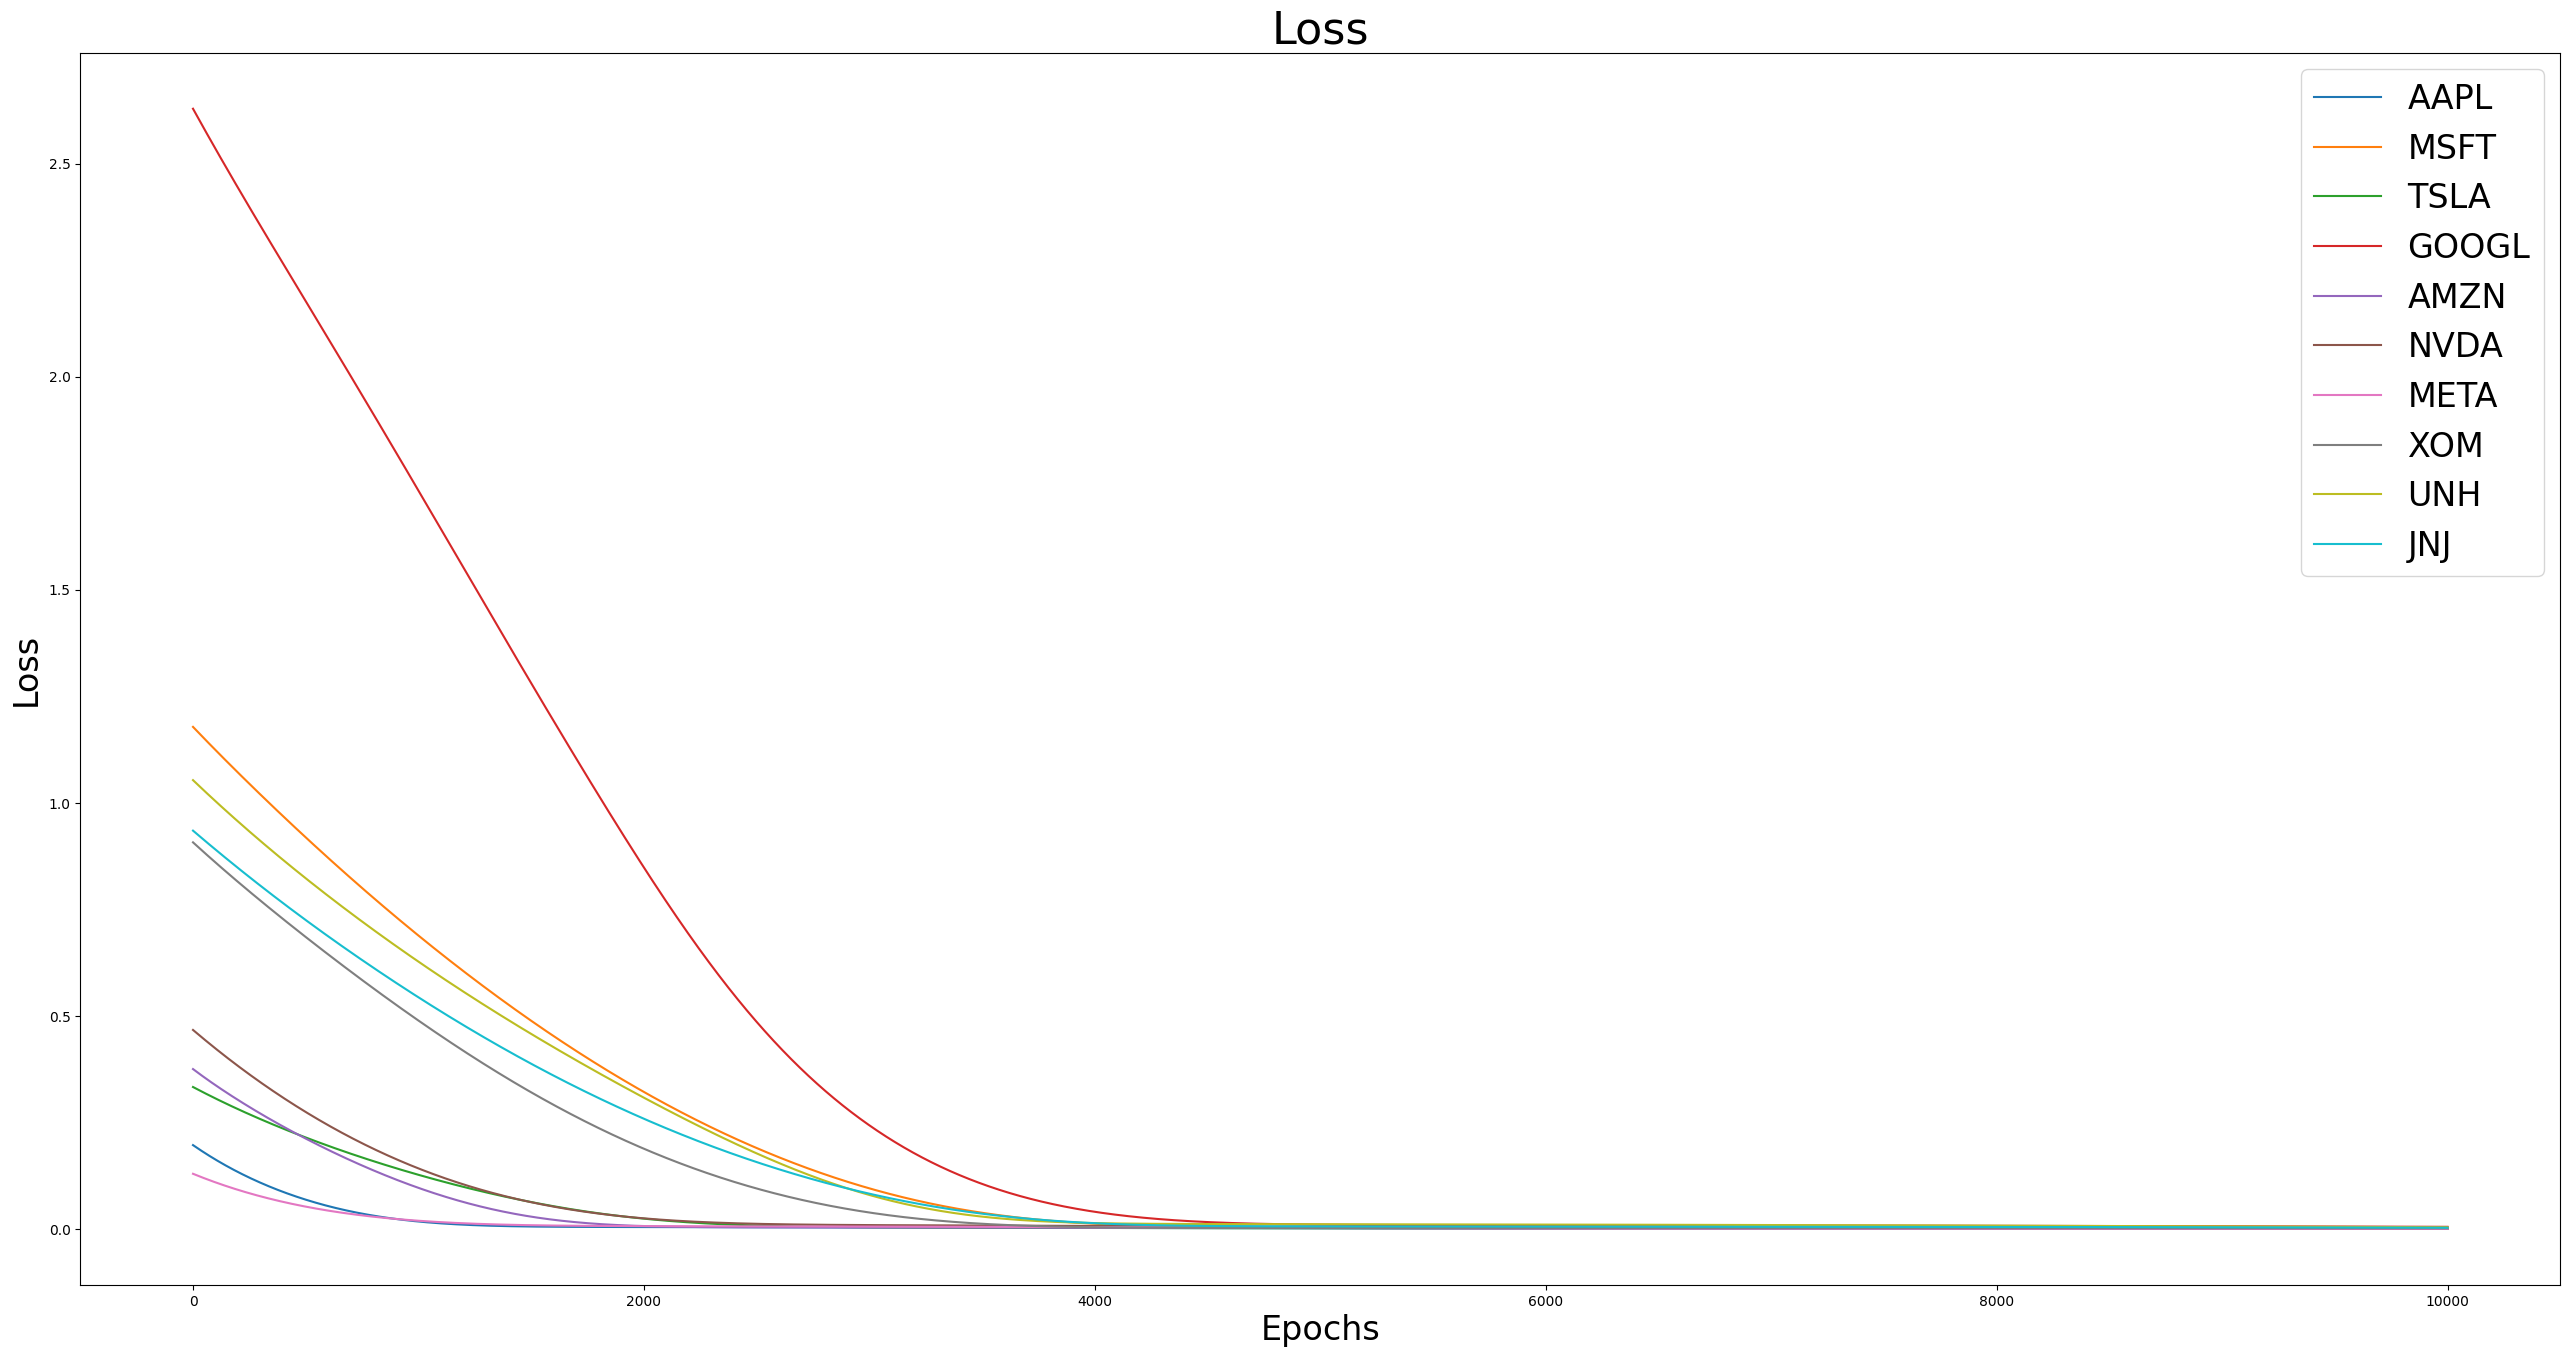

In [26]:
# Plot of losses over training
plt.figure(figsize=(32, 16))
plt.plot(turba_losses, label=TICKERS)
plt.title("Loss", fontsize=32)
plt.xlabel("Epochs", fontsize=24)
plt.ylabel("Loss", fontsize=24)
plt.legend(fontsize=24)
plt.show()

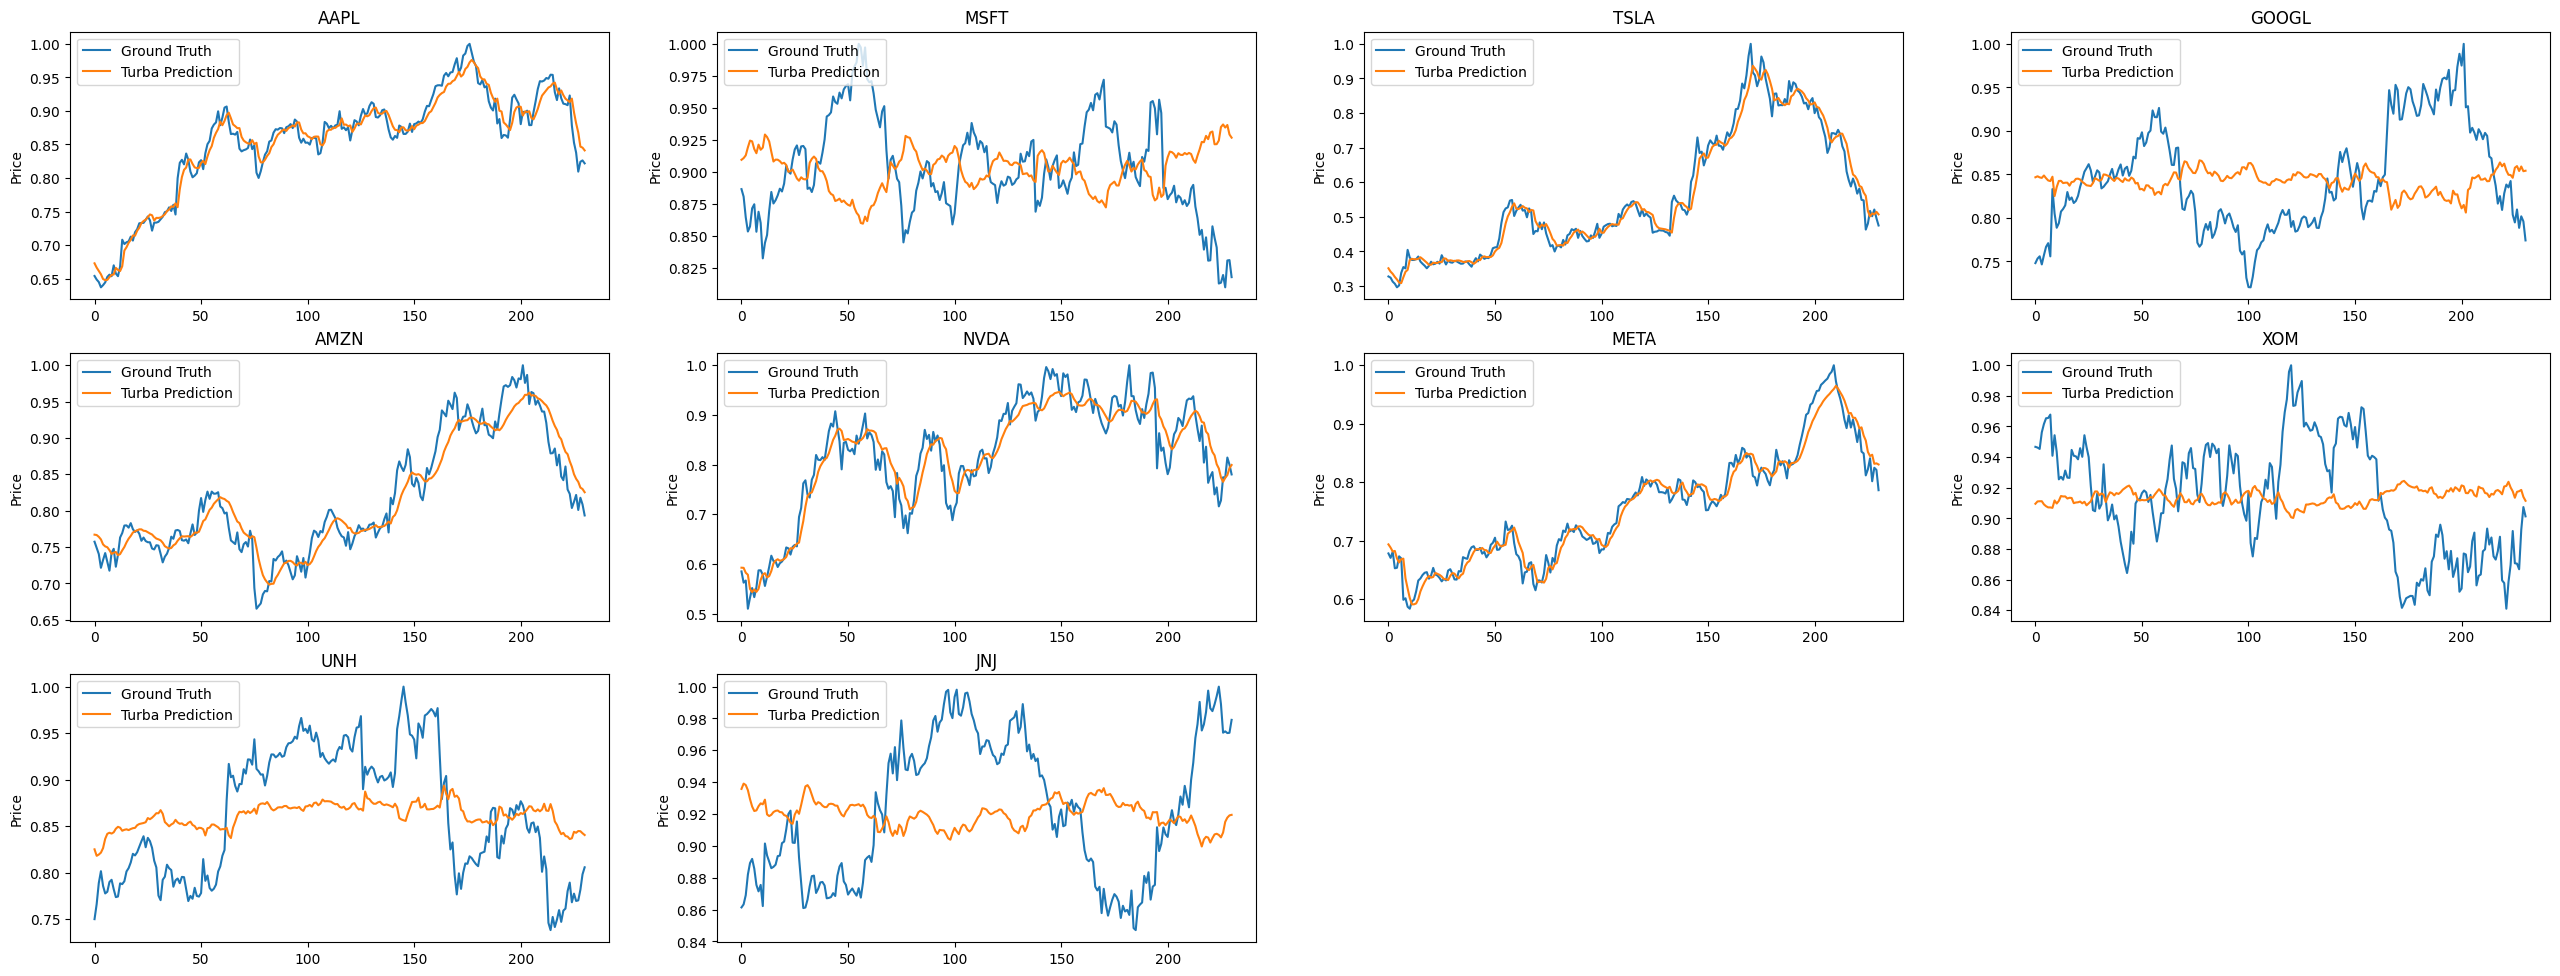

In [27]:
# Subplot of predictions vs ground truth (x by x)
fig = plt.figure(figsize=(32, 16))

# Shared axes
for i in range(SWARM_SIZE):
    ax = fig.add_subplot(
        int(np.ceil(np.sqrt(SWARM_SIZE))), int(np.ceil(np.sqrt(SWARM_SIZE))), i + 1
    )

    # Title
    ax.set_title(TICKERS[i])

    # Axes
    ax.set_ylabel("Price")

    # Data
    ax.plot(y_data[i], label="Ground Truth")
    ax.plot(turba_predictions[i], label="Turba Prediction")

    # Legend
    ax.legend(loc="upper left")

plt.show()


## Torch

In [28]:
import torch
import torch.nn as nn


class TorchLSTM(nn.Module):
    def __init__(self, hidden_size=128):
        super(TorchLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(1, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # Initialize hidden and cell state (h_0, c_0) with zeros
        batch_size = x.size(0)
        h_0 = torch.zeros(1, batch_size, self.hidden_size).to(x.device)
        c_0 = torch.zeros(1, batch_size, self.hidden_size).to(x.device)

        # Forward propagate LSTM
        out, (h_n, c_n) = self.lstm(x, (h_0, c_0))  # Shape: (batch, seq_len, hidden_size)

        # Take the last time step output
        final_output = out[:, -1, :]  # Shape: (batch, hidden_size)

        # Fully connected layer to map hidden state to final output
        return self.fc(final_output)  # Shape: (batch, output_size)

In [29]:
torch_models = [TorchLSTM(hidden_size=HIDDEN_SIZE) for _ in range(SWARM_SIZE)]

In [30]:
# Train the PyTorch model
start = time.time()

torch_loss = torch.nn.MSELoss()
torch_losses = []
for idx, torch_model in enumerate(torch_models):
    torch_model.train()
    torch_optimizer = torch.optim.Adam(torch_model.parameters(), lr=LR)

    torch_losses.append([])
    for epoch in range(EPOCHS):
        # Train
        torch_optimizer.zero_grad()
        y_pred = torch_model(torch.Tensor(X_data[idx]))
        loss = torch_loss(y_pred, torch.Tensor(y_data[idx]))
        loss.backward()
        torch_optimizer.step()

        # Logging
        torch_losses[idx].append(loss.item())
        if epoch % 100 == 0:
            print(f"Model {idx} - Epoch {epoch} Loss: {np.mean(torch_losses[idx][-100:])}")

print(f"torch time: {time.time() - start}")

Model 0 - Epoch 0 Loss: 0.717776358127594
Model 0 - Epoch 100 Loss: 0.7081557428836822
Model 0 - Epoch 200 Loss: 0.6893314492702484
Model 0 - Epoch 300 Loss: 0.6707113814353943
Model 0 - Epoch 400 Loss: 0.6521374726295471
Model 0 - Epoch 500 Loss: 0.6335106241703033
Model 0 - Epoch 600 Loss: 0.6147583937644958
Model 0 - Epoch 700 Loss: 0.5958127844333648
Model 0 - Epoch 800 Loss: 0.5766022402048111
Model 0 - Epoch 900 Loss: 0.5570450592041015
Model 0 - Epoch 1000 Loss: 0.537039652466774
Model 0 - Epoch 1100 Loss: 0.5164534270763397
Model 0 - Epoch 1200 Loss: 0.4951142305135727
Model 0 - Epoch 1300 Loss: 0.4728095078468323
Model 0 - Epoch 1400 Loss: 0.4492880177497864
Model 0 - Epoch 1500 Loss: 0.4242532590031624
Model 0 - Epoch 1600 Loss: 0.39734707355499266
Model 0 - Epoch 1700 Loss: 0.36813212603330614
Model 0 - Epoch 1800 Loss: 0.3360980853438377
Model 0 - Epoch 1900 Loss: 0.30071781992912294
Model 0 - Epoch 2000 Loss: 0.2615638160705566
Model 0 - Epoch 2100 Loss: 0.2185237155854702

In [31]:
torch_predictions = []
for idx, torch_model in enumerate(torch_models):
    torch_model.eval()
    torch_predictions.append(torch_model(torch.Tensor(X_data[idx])).detach().numpy())

In [32]:
torch_losses = np.array(torch_losses).T
torch_predictions = np.array(torch_predictions)

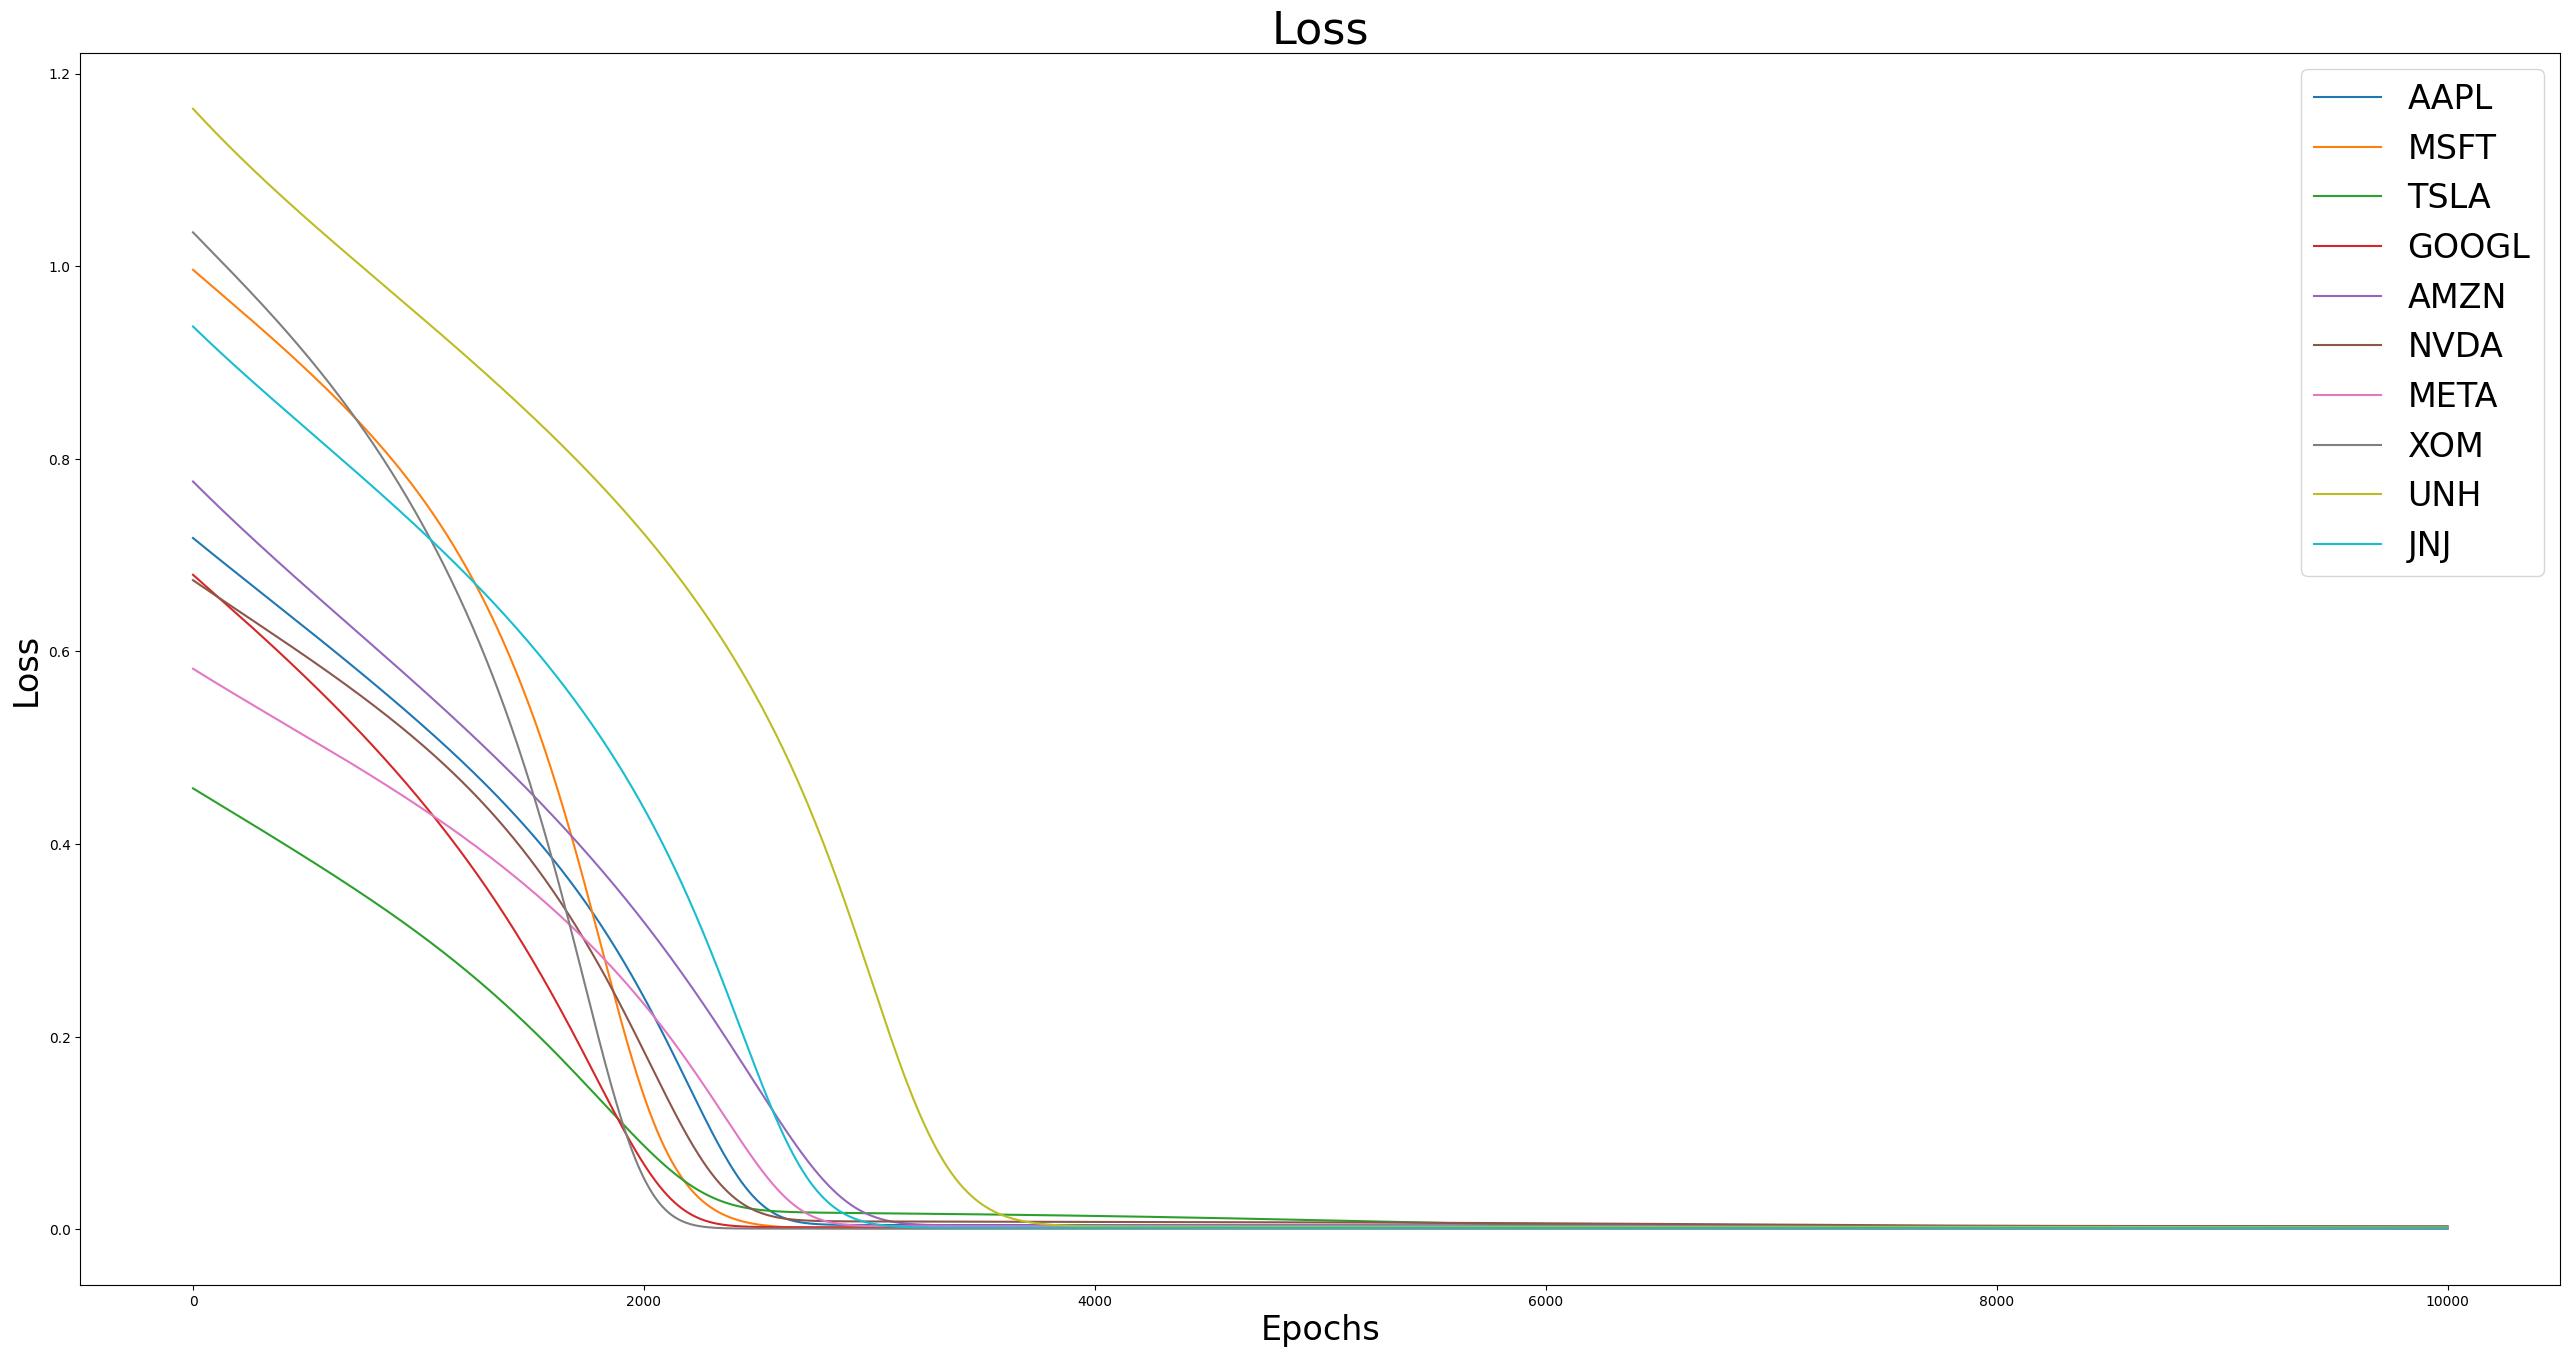

In [33]:
# Plot of losses over training
plt.figure(figsize=(32, 16))
plt.plot(torch_losses, label=TICKERS)
plt.title("Loss", fontsize=32)
plt.xlabel("Epochs", fontsize=24)
plt.ylabel("Loss", fontsize=24)
plt.legend(fontsize=24)
plt.show()

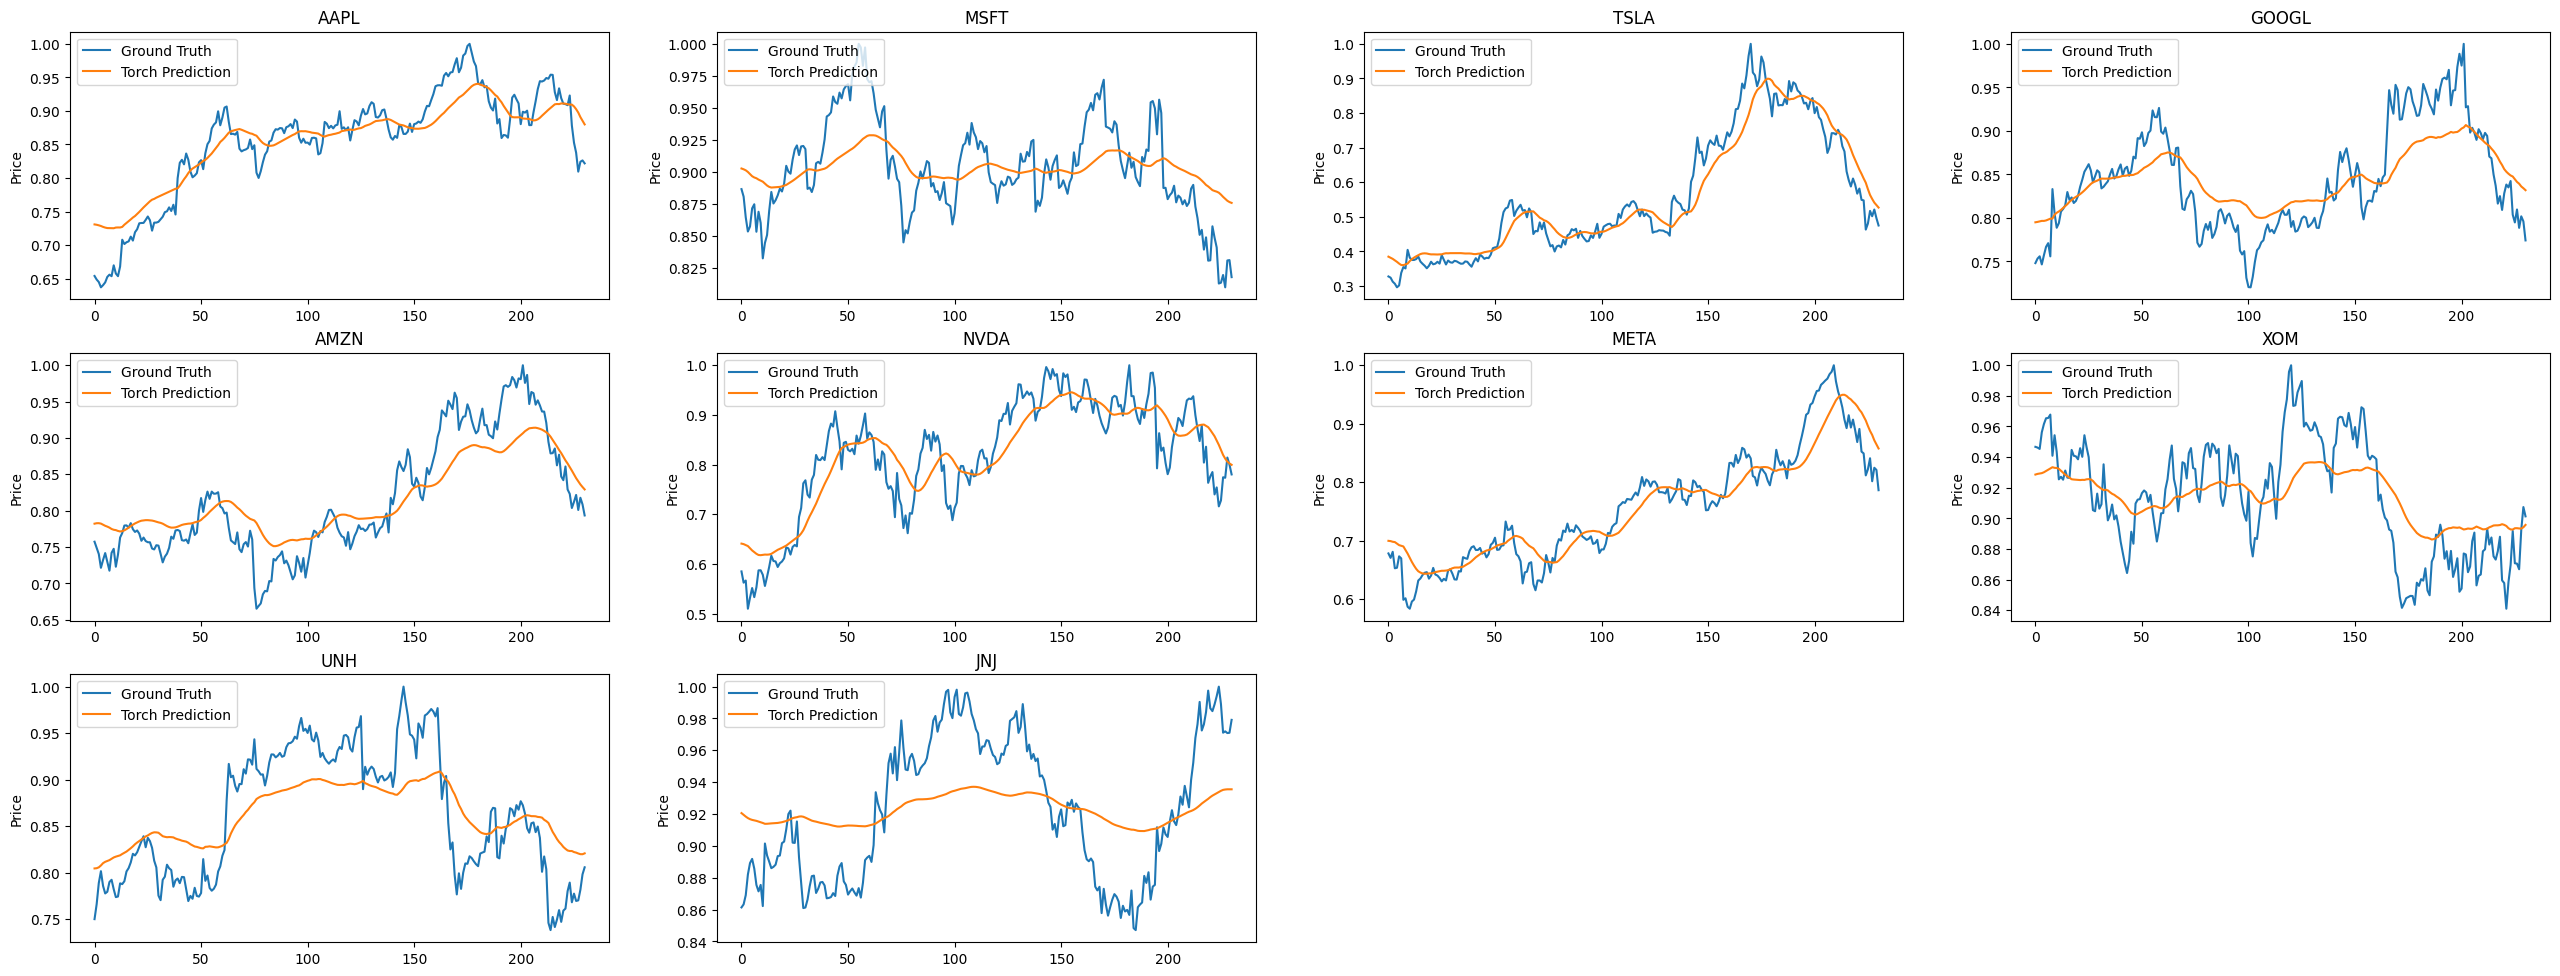

In [34]:
# Subplot of predictions vs ground truth (x by x)
fig = plt.figure(figsize=(32, 16))

# Shared axes
for i in range(SWARM_SIZE):
    ax = fig.add_subplot(
        int(np.ceil(np.sqrt(SWARM_SIZE))), int(np.ceil(np.sqrt(SWARM_SIZE))), i + 1
    )

    # Title
    ax.set_title(TICKERS[i])

    # Axes
    ax.set_ylabel("Price")

    # Data
    ax.plot(y_data[i], label="Ground Truth")
    ax.plot(torch_predictions[i], label="Torch Prediction")

    # Legend
    ax.legend(loc="upper left")

plt.show()

## Final Data

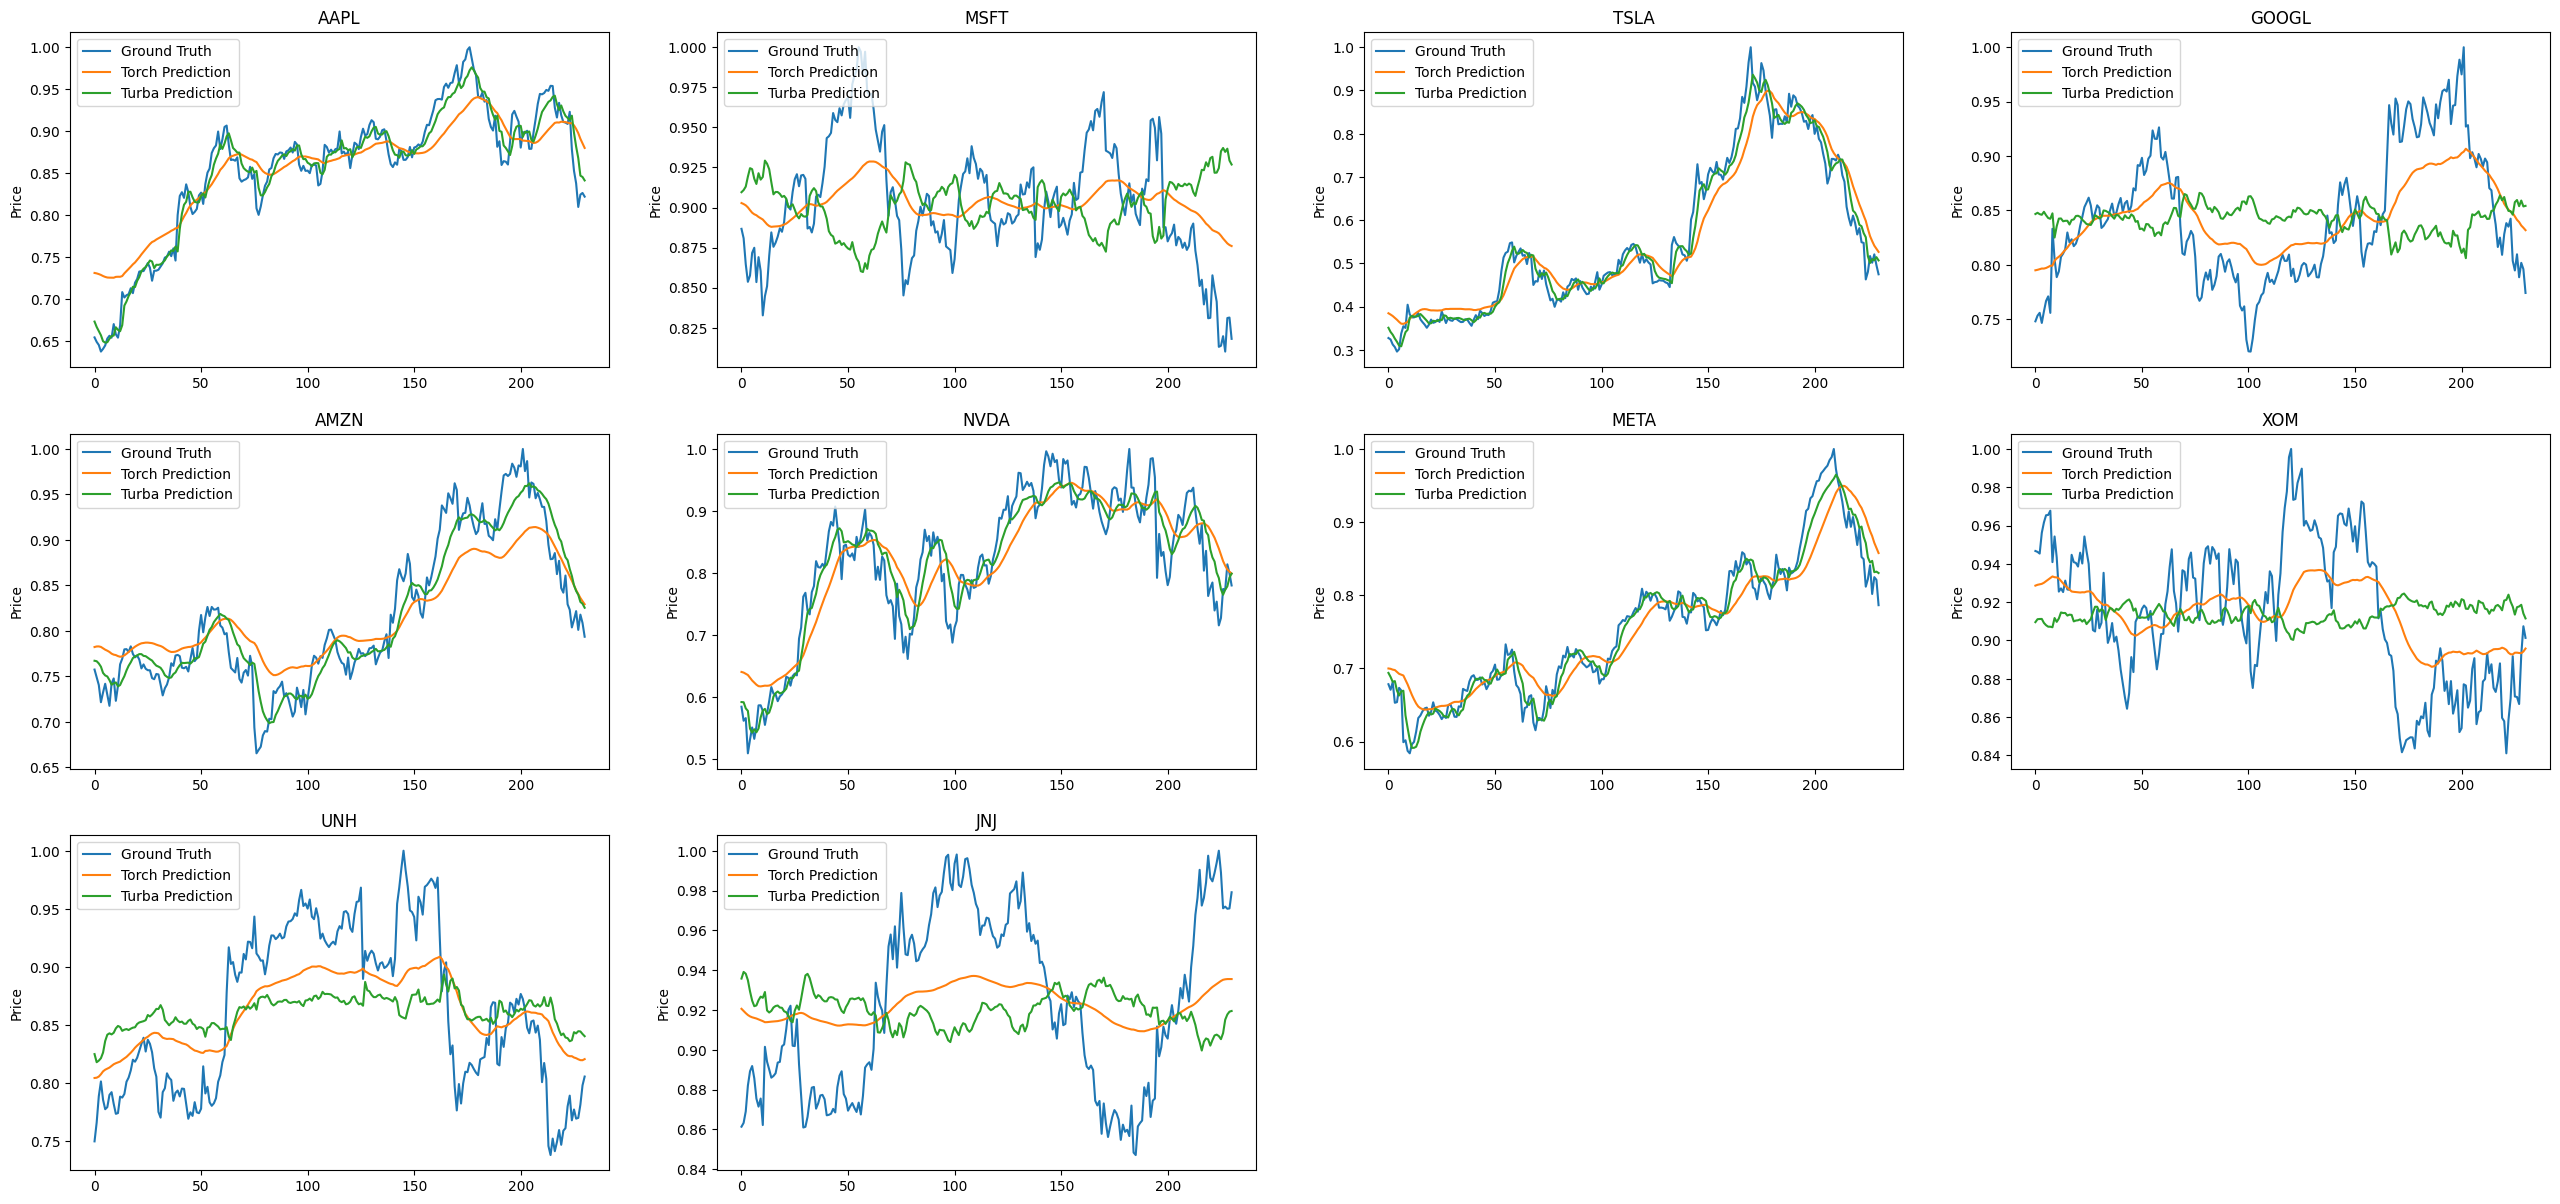

In [35]:
# Subplot of predictions vs ground truth (x by x)
fig = plt.figure(figsize=(32, 20))

# Shared axes
for i in range(SWARM_SIZE):
    ax = fig.add_subplot(
        int(np.ceil(np.sqrt(SWARM_SIZE))), int(np.ceil(np.sqrt(SWARM_SIZE))), i + 1
    )

    # Title
    ax.set_title(TICKERS[i])

    # Axes
    ax.set_ylabel("Price")

    # Data
    ax.plot(y_data[i], label="Ground Truth")
    ax.plot(torch_predictions[i], label="Torch Prediction")
    ax.plot(turba_predictions[i], label="Turba Prediction")

    # Legend
    ax.legend(loc="upper left")

plt.show()